In [2]:
# example from: https://www.kaggle.com/code/ktattan/lda-and-document-similarity

In [3]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cameron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cameron/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head(3)

/tmp/ipykernel_3374/2857451255.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['title'].fillna(value="", inplace=True)


,uuid,author,title,text,language,site_url,country
0,7f90d71cc69893f4c91e8a55f2c4da52d88cd7c1,Fed Up,SAY GOODBYE! These 23 Hollywood Celebs Threate...,\nWho? Comedian. \nWhere would she move? Spain...,english,100percentfedup.com,US
1,c1bcb3502dd845655fa38b30d34b4c5a1355168c,noreply@blogger.com (Alexander Light),"Report: Eating Raw Weed Prevents Bowel Cancer,...",Print Email http://humansarefree.com/2016/11/r...,english,humansarefree.com,US
2,09c532301790f24d75e25675e5bad25af3206a3e,Joan Workman,,It's in the Clinton pockets under the cover up...,english,westernjournalism.com,US


In [8]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [9]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

In [12]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 1.238433881600698 min


In [13]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280

In [14]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('franconia', 1),
 ('tricar', 1),
 ('plough', 1),
 ('gambro', 1),
 ('regeneron', 1),
 ('dentzer', 1),
 ('xarelto', 1),
 ('markowitz', 1),
 ('addictionthat', 1),
 ('botticelli', 1)]

In [15]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('beek', 13),
 ('je', 13),
 ('archer', 13),
 ('normandi', 13),
 ('getoutthevot', 13),
 ('bimbo', 13),
 ('judah', 13),
 ('rootsactionorg', 13),
 ('asparagu', 13),
 ('soral', 13)]

In [17]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)

In [18]:
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [19]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [20]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 345.66828518248764 
minimum document length 0 
maximum document length 11575


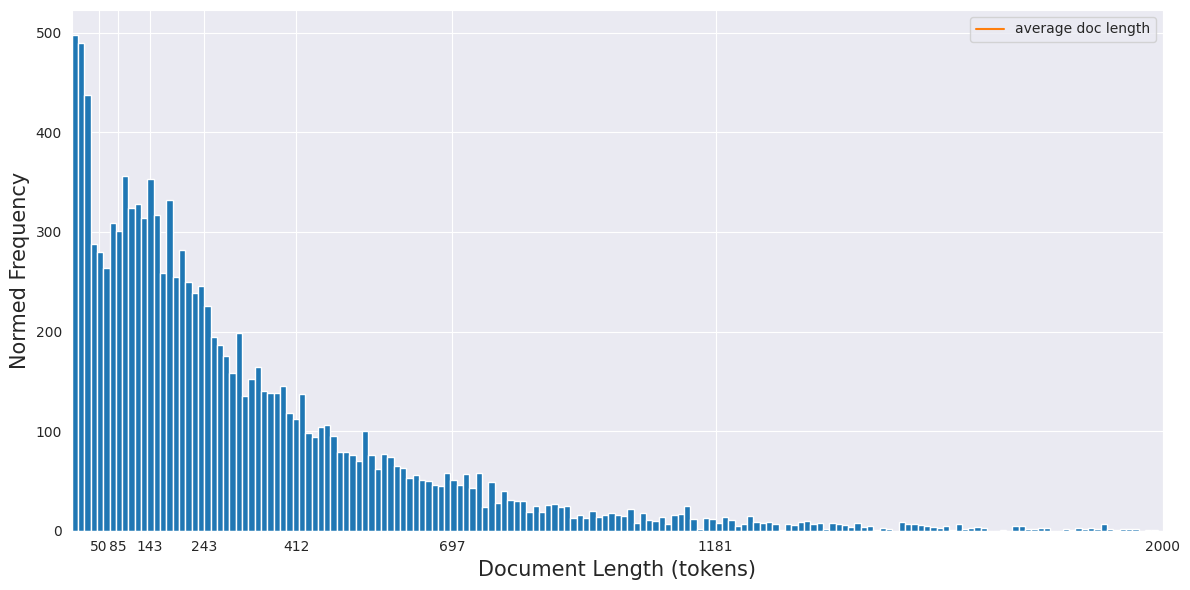

In [25]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins )  #, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')  # this does not show... 
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [26]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 10812 articles


In [27]:
df.head(3)

,uuid,author,title,text,language,site_url,country,tokenized
0,7f90d71cc69893f4c91e8a55f2c4da52d88cd7c1,Fed Up,SAY GOODBYE! These 23 Hollywood Celebs Threate...,\nWho? Comedian. \nWhere would she move? Spain...,english,100percentfedup.com,US,"[comedian, would, move, spain, buy, hous, anot..."
1,c1bcb3502dd845655fa38b30d34b4c5a1355168c,noreply@blogger.com (Alexander Light),"Report: Eating Raw Weed Prevents Bowel Cancer,...",Print Email http://humansarefree.com/2016/11/r...,english,humansarefree.com,US,"[print, email, cannabi, taken, differ, form, w..."
2,336515db559ebe21c4c52741d3f35b34afd0c652,Kaitlyn Stegall,Israel preparing for one-sided UN Security Cou...,"November 11, 2016 Israel preparing for one-sid...",english,endtime.com,US,"[novemb, israel, prepar, onesid, un, secur, co..."


In [40]:
# create a mask of binary values
mask = np.random.rand(len(df)) < 0.999

In [41]:
len(mask)

10812

In [42]:
trues = [m for m in mask if m == True]

In [43]:
len(trues)

10796

In [47]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [49]:
print(len(df),len(train_df),len(test_df))

10812 10797 15


In [50]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [51]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  10812 articles:  0.722571325302124 min


In [52]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(97,
  '0.071*"film" + 0.057*"food" + 0.051*"industri" + 0.046*"product" + 0.035*"organ" + 0.030*"produc" + 0.030*"agricultur" + 0.029*"farmer" + 0.023*"sale" + 0.021*"crop" + 0.018*"monsanto" + 0.016*"andrew" + 0.015*"thanksgiv" + 0.013*"festiv" + 0.013*"chain" + 0.012*"sell" + 0.012*"mi" + 0.011*"pesticid" + 0.011*"us" + 0.011*"made"'),
 (80,
  '0.037*"imag" + 0.035*"photo" + 0.021*"use" + 0.020*"read" + 0.017*"sign" + 0.017*"email" + 0.016*"copyright" + 0.015*"click" + 0.015*"credit" + 0.014*"pictur" + 0.014*"spirit" + 0.013*"name" + 0.013*"address" + 0.013*"person" + 0.011*"join" + 0.011*"cook" + 0.011*"design" + 0.010*"without" + 0.010*"materi" + 0.010*"batteri"'),
 (94,
  '0.091*"human" + 0.088*"right" + 0.058*"un" + 0.031*"council" + 0.029*"intern" + 0.024*"peopl" + 0.015*"farm" + 0.013*"organ" + 0.010*"freedom" + 0.009*"seeker" + 0.009*"violat" + 0.009*"world" + 0.008*"must" + 0.007*"nation" + 0.007*"margaret" + 0.006*"shelter" + 0.006*"unit" + 0.006*"exploit" + 0.006*"activis

In [53]:
lda.show_topic(topicid=4, topn=20)

[('ukrain', 0.052390397),
 ('ukrainian', 0.031216085),
 ('cia', 0.021270117),
 ('coup', 0.018913673),
 ('govern', 0.01881791),
 ('pentagon', 0.017699854),
 ('soviet', 0.016900392),
 ('militari', 0.014533196),
 ('regim', 0.013732729),
 ('kiev', 0.012127588),
 ('presid', 0.011649687),
 ('assassin', 0.011547236),
 ('intellig', 0.010662025),
 ('oper', 0.010275734),
 ('washington', 0.009960502),
 ('offici', 0.0094511295),
 ('war', 0.008608692),
 ('countri', 0.008322823),
 ('rothschild', 0.008183591),
 ('us', 0.007725264)]

In [54]:
lda.show_topic(topicid=85, topn=20)

[('school', 0.21841736),
 ('student', 0.13766748),
 ('educ', 0.06999151),
 ('colleg', 0.062155094),
 ('petit', 0.041890424),
 ('kid', 0.03192819),
 ('univers', 0.022871051),
 ('parent', 0.019579845),
 ('commun', 0.018543696),
 ('board', 0.018135596),
 ('children', 0.017255437),
 ('york', 0.015771098),
 ('program', 0.0155399265),
 ('transgend', 0.014908756),
 ('cancel', 0.01431761),
 ('high', 0.013841725),
 ('issu', 0.012871349),
 ('public', 0.012856512),
 ('district', 0.012119639),
 ('bathroom', 0.01165978)]

In [55]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

1142


In [56]:
print(train_df.iloc[random_article_index,3])

Syrian War Report – October 27, 2016: Russian Strikes Destroyed Over 300 Terrorists’ Oil Facilities ‹ › South Front Analysis & Intelligence is a public analytical project maintained by an independent team of experts from the four corners of the Earth focusing on international relations issues and crises. They focus on analysis and intelligence of the ongoing crises and the biggest stories from around the world: Ukraine, the war in Middle East, Central Asia issues, protest movements in the Balkans, migration crises, and others. In addition, they provide military operations analysis, the military posture of major world powers, and other important data influencing the growth of tensions between countries and nations. We try to dig out the truth on issues which are barely covered by governments and mainstream media. Deterioration of Interracial Relations During Barack Obama’s Presidency By South Front on October 27, 2016 …from SouthFront 
Inter-racial conflict in the US continues to escala

In [57]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

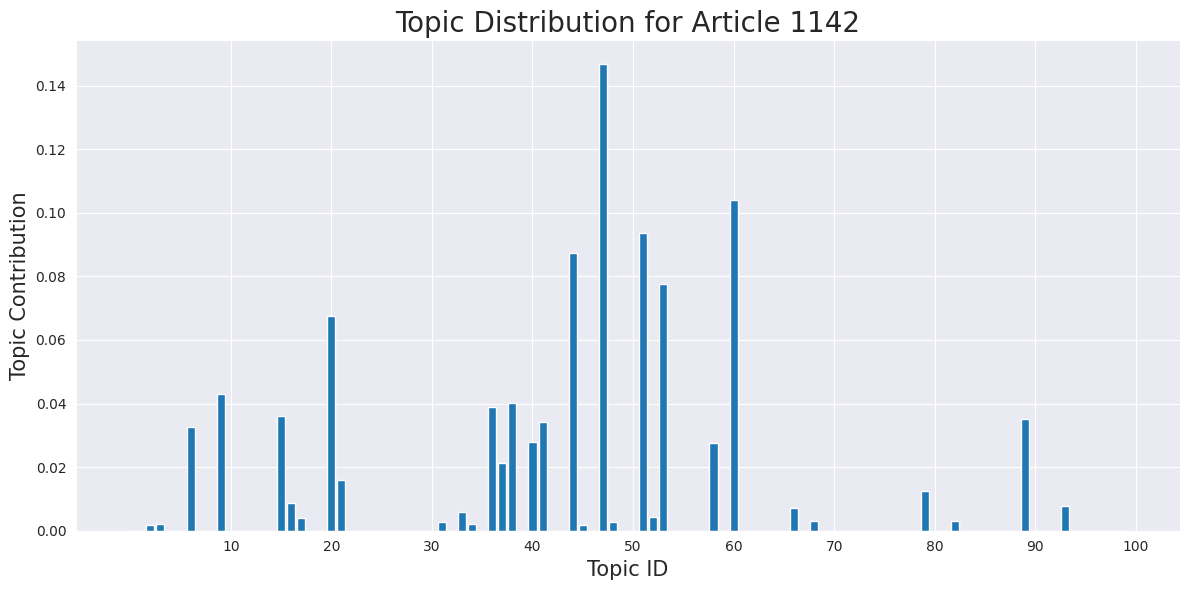

In [58]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [59]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

47 [('econom', 0.01787773), ('system', 0.014771509), ('govern', 0.011161161), ('global', 0.010072405), ('polit', 0.0084472215), ('world', 0.008383163), ('polici', 0.008382486), ('economi', 0.007820464), ('nation', 0.007005057), ('power', 0.006877433)] 

60 [('polic', 0.07764925), ('offic', 0.05566726), ('arrest', 0.024043722), ('said', 0.023791103), ('cop', 0.020690946), ('violenc', 0.02011289), ('report', 0.015418637), ('charg', 0.014522885), ('accord', 0.011870582), ('shoot', 0.01077371)] 

51 [('black', 0.16425651), ('white', 0.115203924), ('racist', 0.0238516), ('peopl', 0.022883229), ('live', 0.021559477), ('racism', 0.019194325), ('race', 0.018473024), ('color', 0.017114956), ('matter', 0.01473385), ('racial', 0.013806462)] 

44 [('state', 0.02698032), ('unit', 0.01937746), ('secur', 0.018126767), ('countri', 0.0142513), ('intern', 0.013363834), ('also', 0.011850399), ('nation', 0.011019332), ('member', 0.009468684), ('us', 0.008820436), ('relat', 0.008547374)] 

53 [('year', 0.0